# Automated Kernel Density Estimation for extracting Wildlife Vehicle Accidents on Roads

This Notebook describes the python code for extracting Wildlife Vehicle Accident(WVA) Hotspots along roads. The required data sets are the Wildlife Vehicle Accidents (point feature class) and the street (polyline featrure class). I would suggest the Open Street Data Set for road calcualtion (https://download.geofabrik.de/europe/germany/bayern.html). As this data set consists out of polyline features a sql-query can help to filter out the wanted street segment (e.g. B20). For further information on WVA and Kernel Density Estimation (KDE) see also this storymap: https://storymaps.arcgis.com/stories/bede15cf99b94570bd88844a78cd2ec0

ArcPy is a Python site package that provides a useful and productive way to perform geographic data analysis, data conversion, data management, and map automation with Python. It is mandantory to import arcpy and usually the first step working with automatisation processes in ArcGISPro.

In [1]:
import arcpy
from arcpy.sa import KernelDensity, ExtractByMask
arcpy.CheckOutExtension("3D")
arcpy.CheckOutExtension("spatial")


The first step is to set a Geodatabase and a workspace. Please change the following paths accordingly. 

In [ ]:
wildlifeGDB = r"C:\Users\felix\OneDrive\Dokumente\ArcGIS\Projects\Final_Assignment\Final_Assignment.gdb"
arcpy.env.workspace = wildlifeGDB
arcpy.env.overwriteOutput = True

These are the input feature layers. Please choose the right data sets and select a output_name of your choice which will be used for the final output product. 

In [ ]:
inputStreet = "B20_BGD"
inputAccidents = "WildlifeAccidents_LDK_BGD"
inputName = "choose your name in here "

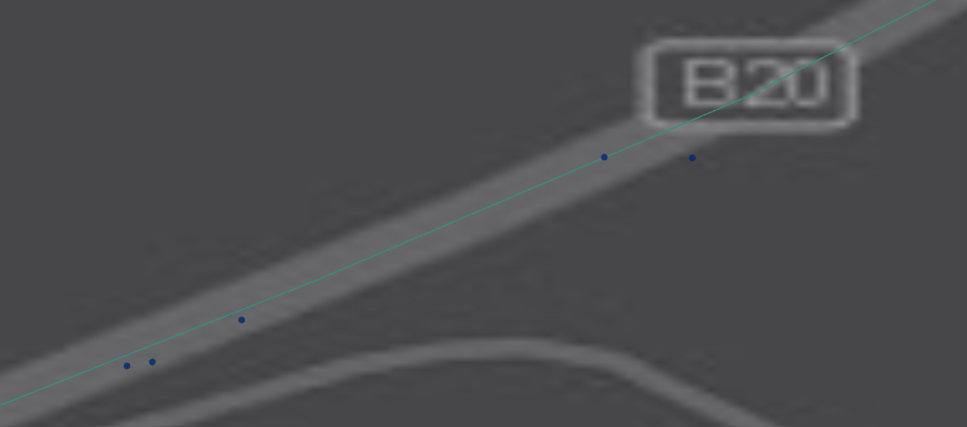

For choosing the right WVA we have to buffer the street. Otherwise due to coordinate inaccuracy the street-polyline will not be intersected with the accidents and the according accidents will not be belonging to the street. This would be bad for calculation. The buffer of 400m is set for masking reasons only to make the output eye-friendly. 

In [ ]:
# Buffered inputStreet Dataset in Diameter D_40 + D_400
# Buffer 40
# Input variables
output_buffer = wildlifeGDB + "\\" + "bufferD40"
buffer_distance = "20 meters"
# Buffer Function
arcpy.analysis.Buffer(inputStreet, output_buffer, buffer_distance, dissolve_option = "ALL")

# Buffer 400
output_buffer = wildlifeGDB + "\\" + "bufferD400"
buffer_distance = "200 meters"
arcpy.analysis.Buffer(inputStreet, output_buffer, buffer_distance, dissolve_option = "ALL")

After buffering, of course intersecting is important. The next step then is the Kernel Density Estimation. 

In [ ]:
# Intersect inputStreet with all accidents (inputAccidents) to get the accidents lying on the inputStreet
in_features = ["bufferD40", inputAccidents]
out_feature_class = wildlifeGDB + "\\" + "intersectedAccidents"
join_attributes = "ONLY_FID"
output_type = "point"
arcpy.analysis.Intersect(in_features, out_feature_class, join_attributes)

The Kernel Density Estimation is the most important step in all this calculation process and had to be checked several times to choose the right parameters. The in_feature_class are the intersected accidents. Population field is set to "NONE" as every accident counts one. The population field is the count or quantity to be spread across the landscape to create a continuous surface. The search radius is the most important value and represents the distance within to calculate the density. Units are based on the linear unit of the projection of the output spatial reference. A mask of 400m is set as we are just interested in the KDE-values alongside the road. 

In [ ]:
# KERNELFUNCTION
# use the intersected accidents for calculation
in_features = "intersectedAccidents"
# KDE Function
KDE = arcpy.sa.KernelDensity(in_features, population_field="NONE", search_radius=0.01, area_unit_scale_factor="SQUARE_MAP_UNITS", out_cell_values="DENSITIES", method="PLANAR", in_barriers="")

# set a mask over the calculation
KDE = ExtractByMask(KDE, "bufferD400")
# saves the kernel in the database
KDE.save(wildlifeGDB + "\\" + inputName)
#OUTPUT #1

arcpy.AddMessage("Kernel complete")
arcpy.AddMessage (inputName + " created")

As the output comes out with stretched KDE values and we would like to have classified Values in 5 classes we tried to use the ApplySymbology function. This function transfers the symbology from a sample Symbology set (sampleSymbology) to the newly created Kernel Density Raster Output. We also tried the ColorRamp function but we are still looking for other possibilities to make this step happen the way we want it to happen. This is the most problematic step and if there is no proper solution we have to write two scripts and transfer these steps manually. 

In [ ]:
# Apply Symbolog from Layer to give the right symbology to our created KDE
#KDE_buffer400 = arcpy.Raster("KDE_buffer400")
sampleSymbology = arcpy.Raster("sampleSymbology")

# Process: Apply Symbology From Layer (Apply Symbology From Layer) (management)
Updated_Symbology = arcpy.management.ApplySymbologyFromLayer(in_layer=KDE, in_symbology_layer=sampleSymbology, symbology_fields=[["VALUE_FIELD", "", ""]], update_symbology="UPDATE")[0]

A reclassification is mandatory for intersecting the buffered Street (D40) with the final output. As a raster and a vector layer cannot be instersected we have to transfer the raster to a polygon data set. 

In [ ]:
# Process: Reclassify (Reclassify) (sa)
Output_raster = wildlifeGDB + "\\" + inputName + "Reclassified"
Reclassify = Output_raster
Output_raster = arcpy.sa.Reclassify(in_raster=Updated_Symbology, reclass_field="VALUE", remap="5656,884277 57692,648788 1;57692,648788 93959,999810 2;93959,999810 129438,930159 3;129438,930159 167283,122530 4;167283,122530 206704,156250 5", missing_values="DATA")
Output_raster.save(Reclassify)
#OUTPUT #2

In [ ]:
# Process: Raster to Polygon (Raster to Polygon) (conversion)
Output_polygon_features = wildlifeGDB + "\\" + inputName + "PolygonKDE"
PolygonKDE = Output_polygon_features
arcpy.conversion.RasterToPolygon(in_raster=Output_raster, out_polygon_features=Output_polygon_features, simplify="SIMPLIFY", raster_field="VALUE", create_multipart_features="SINGLE_OUTER_PART", max_vertices_per_feature=None)
#OUTPUT #3

In [ ]:
# Intersect the just created Polygon with the Buffered Street to get the final Product
in_features = ["bufferD40", Output_polygon_features]
out_feature_class = wildlifeGDB + "\\" + inputName + "intersectedAccidents"
outFeatureClass = out_feature_class
join_attributes = "ONLY_FID"
output_type = "point"
arcpy.analysis.Intersect(in_features, out_feature_class, join_attributes)
#OUTPUT #4

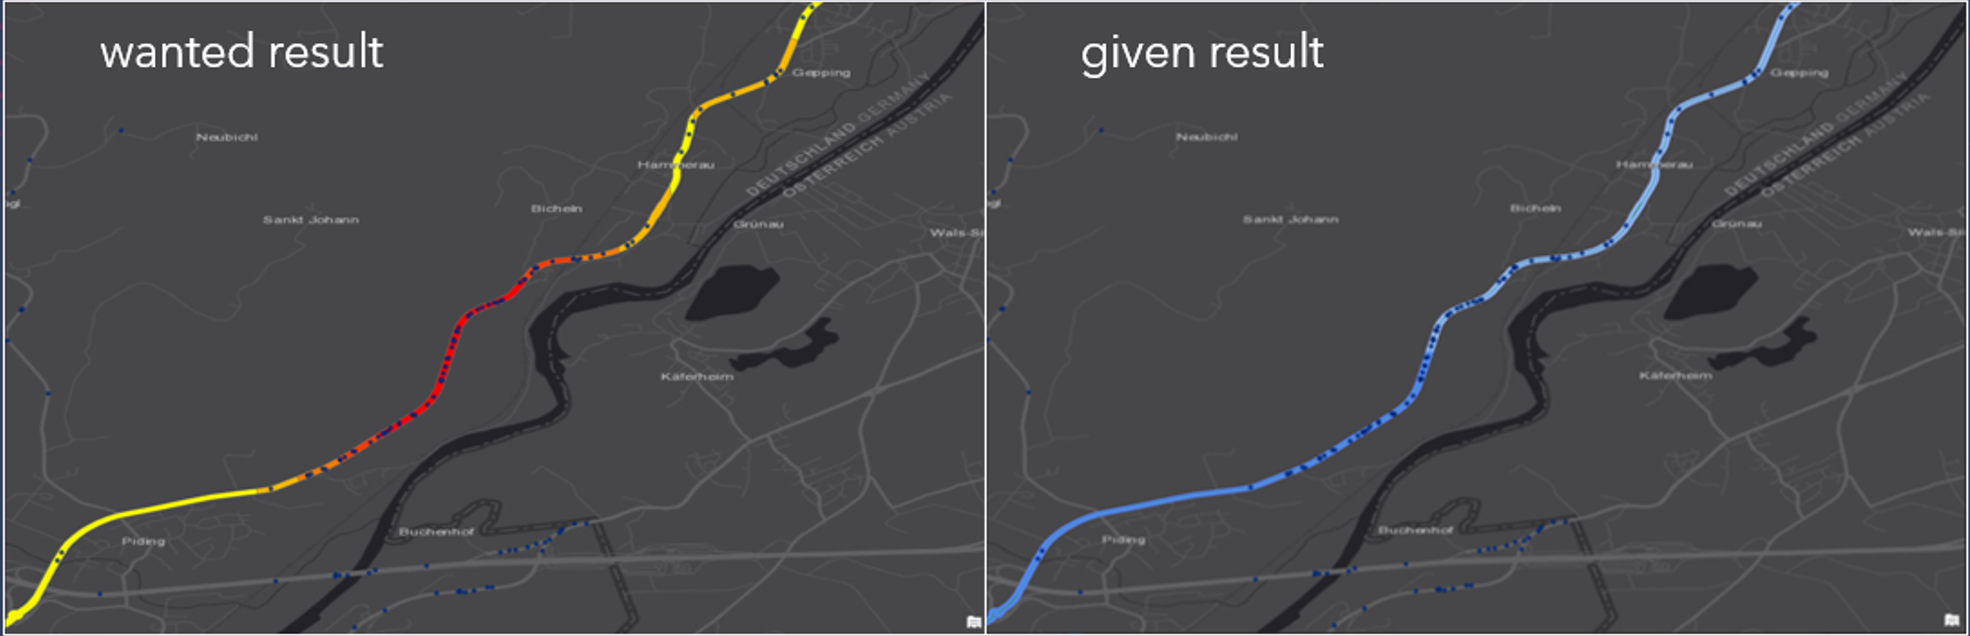